Does votality index can predict the nasdaq index in the future.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [19]:
df1 = pd.read_csv('/content/2014to2023_NasdaqIndexHistoricData.csv')
df2 = pd.read_csv('/content/2014to2023_VixValuesHistoricData.csv')
df3 = pd.read_excel('/content/2014to2023_SandP500IndexHistoricData.xlsx')

df1['Date'] = pd.to_datetime(df1['Date'])
df2['Date'] = pd.to_datetime(df2['Date'])
df3['Date'] = pd.to_datetime(df3['Date'])

とりあえず、データの中身をチェック

In [47]:
df2.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-01,14.320000,14.59,12.16,12.920000,12.920000,0
1,2014-01-08,13.040000,13.65,11.82,12.280000,12.280000,0
2,2014-01-15,12.150000,13.42,11.81,12.870000,12.870000,0
3,2014-01-22,12.570000,18.99,12.55,15.800000,15.800000,0
4,2014-01-29,17.950001,21.48,15.96,19.110001,19.110001,0


In [ ]:
df3.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,2014-01-01,1845.86,1845.86,1823.73,1837.88,1837.88,12661470000
1,2014-01-08,1837.90,1843.45,1815.52,1838.88,1838.88,17513620000
2,2014-01-15,1840.52,1850.84,1832.38,1843.80,1843.80,14677700000
3,2014-01-22,1844.71,1846.87,1772.88,1792.50,1792.50,19447900000
4,2014-01-29,1790.15,1798.77,1739.66,1755.20,1755.20,20365670000


https://qiita.com/yoinhu/items/e0039309a47c75dade05

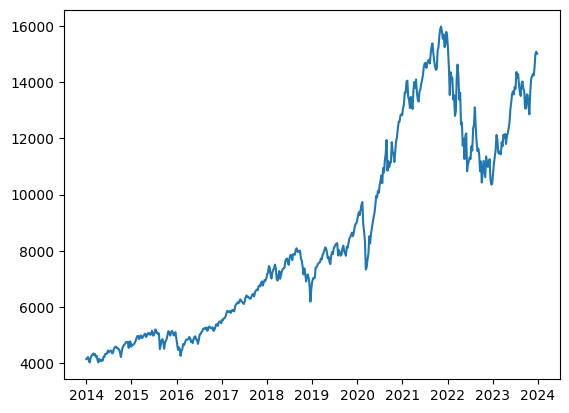

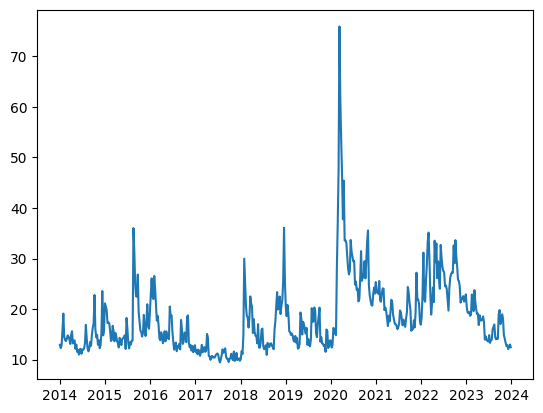

In [49]:
plt.plot(df1['Date'], df1['Close'])
plt.show()

plt.plot(df2['Date'], df2['Close'])
plt.show()

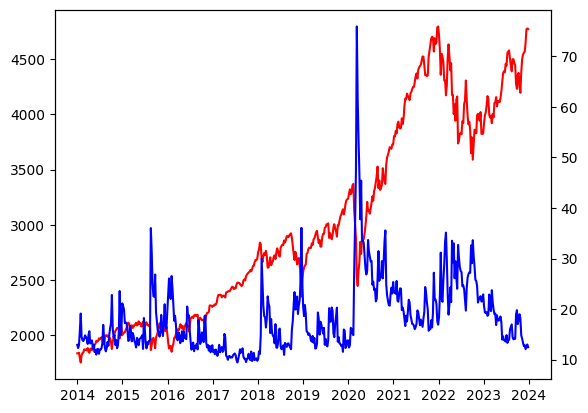

In [50]:
# visualize
fig = plt.figure()

ax1 = fig.subplots()
ax2 = ax1.twinx()

ax1.plot(df3['Date'], df3['Close*'], color='red')
ax2.plot(df2['Date'], df2['Close'], color='blue')
plt.show()

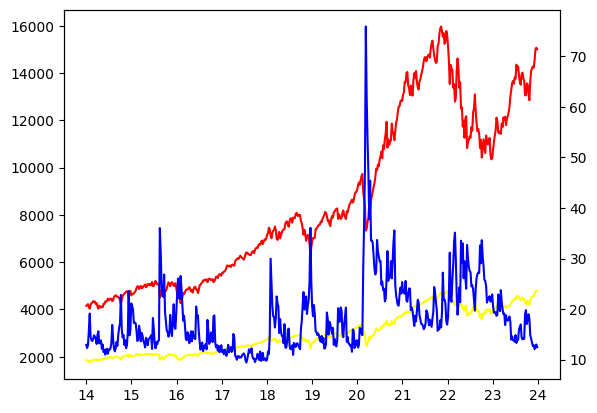

In [24]:
# arrange horizontal axis
import datetime
import matplotlib.ticker as ticker
from matplotlib.dates import date2num
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# visualize
fig = plt.figure()

ax1 = fig.subplots()
ax2 = ax1.twinx()

years = mdates.YearLocator()   # 毎年
years_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(DateFormatter('%y'))


ax1.plot(df1['Date'], df1['Close'], color='red')
ax1.plot(df3['Date'], df3['Close*'], color='yellow')
ax2.plot(df2['Date'], df2['Close'], color='blue')

plt.show()

出来そうなことといえば、すでにあるSandP500のデータとvixを使って、次のSandP500を予測すること

In [32]:
# データの前処理
df_merge = pd.merge(df1, df2, on='Date')
df_merge = pd.merge(df_merge, df3, on='Date')
df_merge = df_merge[['Date', 'Close_x', 'Close_y', 'Close*']]
df_merge.columns = ['Date', 'Nasdaq', 'Vix', 'SandP500']
df_merge.head()

,Date,Nasdaq,Vix,SandP500
0,2014-01-01,4153.180176,12.920000,1837.88
1,2014-01-08,4183.020020,12.280000,1838.88
2,2014-01-15,4225.759766,12.870000,1843.80
3,2014-01-22,4097.959961,15.800000,1792.50
4,2014-01-29,4031.520020,19.110001,1755.20


In [33]:
def arrange_seriesedata(values):
  # 空のリストを作成
  sequences = []

  # 20個ずつのデータを取り出す
  for i in range(len(values) - 20 + 1):
      sequence = values[i:i+20]
      sequences.append(sequence)

  # sequencesは20個ずつのデータを保管したリストです
  sequences = np.array(sequences)
  return sequences

In [34]:
wave1 = arrange_seriesedata(df_merge['SandP500'].values)
wave2 = arrange_seriesedata(df_merge['Vix'].values)

y_future = []
for i in range(len(wave1)):
  y_future.append(wave1[i][-1])

y_future = np.array(y_future)

In [37]:
# 予測用データ
y_future = y_future[1:]

# 説明変数
X = np.concatenate([wave1[:-1], wave2[:-1]], axis=1)
X.shape

(502, 40)

In [53]:

import lightgbm as lgb

X_train = X[:420]
X_test = X[420:]
y_train = y_future[:420]
y_test = y_future[420:]


In [54]:
# make model and train
# データセットを作成
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# パラメータを設定
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# モデルを訓練
model = lgb.train(params, train_data, valid_sets=test_data, num_boost_round=1000)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5640
[LightGBM] [Info] Number of data points in the train set: 420, number of used features: 40
[LightGBM] [Info] Start training from score 2841.503974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [56]:
# 予測結果を表示
for i in range(len(X_test)):
  new_data = X_test[i]
  prediction = model.predict(new_data.reshape(1, -1))

  print(f"予測結果: {prediction}, 実際: {y_test[i]}")


予測結果: [4137.41634069], 実際: 3735.48
予測結果: [4064.59498496], 実際: 3764.79
予測結果: [4069.65032164], 実際: 3821.55
予測結果: [4036.3856201], 実際: 3831.39
予測結果: [4011.95653696], 実際: 3818.8
予測結果: [4060.91645577], 実際: 3936.69
予測結果: [4060.66078891], 実際: 3921.05
予測結果: [4116.52842247], 実際: 4091.19
予測結果: [4037.71563962], 実際: 4122.47
予測結果: [4119.62088394], 実際: 4305.2
予測結果: [4257.08438187], 実際: 4128.73
予測結果: [4115.38440886], 実際: 3986.16
予測結果: [4017.12427169], 実際: 3908.19
予測結果: [3992.94221565], 実際: 3932.69
予測結果: [3985.82729809], 実際: 3855.93
予測結果: [3997.93964107], 実際: 3647.29
予測結果: [4080.07094816], 実際: 3790.93
予測結果: [4062.74184293], 実際: 3588.84
予測結果: [4084.48675739], 実際: 3719.98
予測結果: [4064.70342394], 実際: 3859.11
予測結果: [4043.59500858], 実際: 3856.1
予測結果: [4036.07324766], 実際: 3828.11
予測結果: [3996.3490615], 実際: 3991.73
予測結果: [3983.39153606], 実際: 4003.58
予測結果: [3995.82951972], 実際: 3957.63
予測結果: [4019.97710003], 実際: 3941.26
予測結果: [4025.52103307], 実際: 4019.65
予測結果: [4011.59062406], 実際: 3821.62
予測結果: [3981.48700794], 実際

In [55]:
# 新しいデータ（例えば、X_testの最初のデータ）で予測
y_pred = model.predict(X_test)

# 精度測定
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
# RMSLEを計算
error = rmsle(y_test, y_pred)
print('RMSLE:', error)

RMSLE: 0.03574170382060264


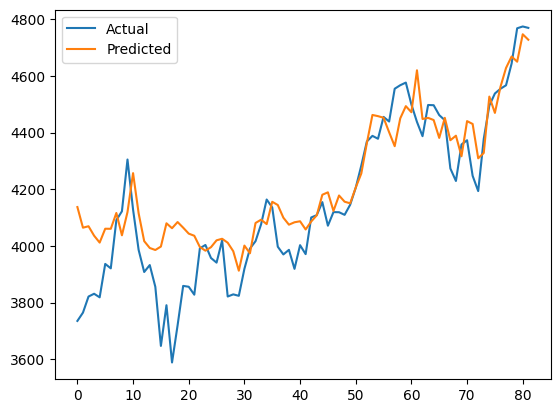

In [60]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# 結果
まあまあな結果。
ただし、正統派の時系列予測ではないため、実際に使える精度ではないと推定

あくまで次のステップの値を予測しているのみ